# 🎯 Lasso Regression - Essential Guide

## 📋 **Table of Contents**
1. [What is Lasso Regression?](#what-is-lasso)
2. [Mathematical Foundation](#math-foundation)
3. [Why Use Lasso?](#why-lasso)
4. [Hyperparameter Selection](#hyperparameter)
5. [Implementation](#implementation)
6. [Comparison with Ridge and OLS](#comparison)

---

## 🎯 **What is Lasso Regression?** {#what-is-lasso}

**Lasso** (Least Absolute Shrinkage and Selection Operator) is a **regularized linear regression** that performs both **feature selection** and **regularization**.

**Key Idea**: Add an L1 penalty that can shrink coefficients to **exactly zero**, effectively removing features.

---

## 🧮 **Mathematical Foundation** {#math-foundation}

### **Lasso Objective Function**
$$\hat{\boldsymbol{\beta}}_{Lasso} = \arg\min_{\boldsymbol{\beta}} \left\{ \|\mathbf{y} - \mathbf{X}\boldsymbol{\beta}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_1 \right\}$$

Where:
- $\lambda \geq 0$ is the **regularization parameter**
- $\|\boldsymbol{\beta}\|_1 = \sum_{j=1}^{p} |\beta_j|$ is the **L1 penalty**

### **Expanded Form**
$$\mathcal{L}(\boldsymbol{\beta}) = \sum_{i=1}^{n} \left(y_i - \sum_{j=1}^{p} x_{ij}\beta_j\right)^2 + \lambda \sum_{j=1}^{p} |\beta_j|$$

### **Key Difference from Ridge**
- **Ridge**: $\lambda \sum_{j=1}^{p} \beta_j^2$ (L2 penalty) → **shrinks** coefficients
- **Lasso**: $\lambda \sum_{j=1}^{p} |\beta_j|$ (L1 penalty) → **zeros out** coefficients

### **No Closed-Form Solution**
Unlike Ridge, Lasso requires **iterative algorithms**:
- Coordinate Descent
- LARS (Least Angle Regression)
- Proximal Gradient Methods

---

## 🤔 **Why Use Lasso?** {#why-lasso}

### **Problems Lasso Solves**
1. **Feature Selection**: Automatically selects relevant features
2. **Overfitting**: Reduces model complexity
3. **Interpretability**: Creates sparse, interpretable models
4. **High-dimensional data**: Works when $p > n$

### **Lasso vs Ridge - Key Differences**

| **Aspect** | **Lasso (L1)** | **Ridge (L2)** |
|------------|----------------|-----------------|
| **Sparsity** | ✅ Exact zeros | ❌ Asymptotic zeros |
| **Feature Selection** | ✅ Automatic | ❌ No |
| **Grouped Features** | Selects one | Keeps all |
| **Solution** | No closed form | Closed form |
| **Interpretability** | High | Medium |

### **When to Use Lasso?**
- Many **irrelevant features** in your data
- Need **automatic feature selection**
- Want **interpretable** sparse models
- **Feature engineering** to identify important variables

---

## 🎛️ **Hyperparameter Selection** {#hyperparameter}

### **Effect of λ (Alpha)**
- **λ = 0**: Regular OLS (no regularization)
- **λ small**: Light regularization, most features kept
- **λ large**: Heavy regularization, few features kept
- **λ → ∞**: All coefficients → 0

### **Cross-Validation for λ**
```python
from sklearn.linear_model import LassoCV
import numpy as np

# Automatic lambda selection with CV
alphas = np.logspace(-4, 1, 50)  # 0.0001 to 10
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

print(f"Best alpha: {lasso_cv.alpha_}")
print(f"Number of non-zero coefficients: {np.sum(lasso_cv.coef_ != 0)}")
```

### **Regularization Path**
```python
from sklearn.linear_model import lasso_path

# Get full regularization path
alphas, coefs, _ = lasso_path(X_train_scaled, y_train, alphas=alphas)

# Plot coefficient paths
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[0]):
    plt.plot(alphas, coefs[i, :])
plt.xscale('log')
plt.xlabel('Alpha (λ)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regularization Path')
plt.grid(True)
```

---

## 💻 **Implementation** {#implementation}

### **Using Scikit-learn**
```python
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Basic Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

# Lasso with automatic alpha selection
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
```

### **Feature Selection with Lasso**
```python
# Fit Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

# Get selected features
selected_features = np.where(lasso.coef_ != 0)[0]
feature_names = [f"Feature_{i}" for i in selected_features]

print(f"Selected {len(selected_features)} features out of {X_train.shape[1]}")
print(f"Selected features: {selected_features}")

# Create reduced dataset with selected features only
X_train_selected = X_train_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]
```

### **Coordinate Descent Algorithm (Conceptual)**
```python
def soft_threshold(x, threshold):
    """Soft thresholding operator for Lasso"""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def lasso_coordinate_descent(X, y, alpha, max_iters=1000, tol=1e-6):
    """
    Simplified Lasso using coordinate descent
    """
    n, p = X.shape
    beta = np.zeros(p)
    
    for iteration in range(max_iters):
        beta_old = beta.copy()
        
        for j in range(p):
            # Compute partial residual
            r_j = y - X @ beta + X[:, j] * beta[j]
            
            # Coordinate update with soft thresholding
            rho_j = X[:, j] @ r_j
            z_j = np.sum(X[:, j] ** 2)
            
            if z_j != 0:
                beta[j] = soft_threshold(rho_j / z_j, alpha / z_j)
            else:
                beta[j] = 0
        
        # Check convergence
        if np.linalg.norm(beta - beta_old) < tol:
            break
    
    return beta
```

### **Important: Feature Scaling**
```python
# Always standardize for Lasso!
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Lasso to scaled data
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
```

---

## ⚖️ **Comparison with Ridge and OLS** {#comparison}

### **Summary Table**

| **Method** | **Penalty** | **Sparsity** | **Feature Selection** | **Best When** |
|------------|-------------|--------------|----------------------|---------------|
| **OLS** | None | No | No | Few features, low noise |
| **Ridge** | $\lambda\sum\beta_j^2$ | No | No | Many relevant features |
| **Lasso** | $\lambda\sum|\beta_j|$ | Yes | Yes | Many irrelevant features |

### **Visual Comparison**
```python
import matplotlib.pyplot as plt
import numpy as np

# Compare all three methods
from sklearn.linear_model import LinearRegression, Ridge, Lasso

models = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}

coefficients = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    coefficients[name] = model.coef_

# Plot coefficients
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x_pos = np.arange(len(coefficients['OLS']))

width = 0.25
ax.bar(x_pos - width, coefficients['OLS'], width, label='OLS', alpha=0.8)
ax.bar(x_pos, coefficients['Ridge'], width, label='Ridge', alpha=0.8)
ax.bar(x_pos + width, coefficients['Lasso'], width, label='Lasso', alpha=0.8)

ax.set_xlabel('Feature Index')
ax.set_ylabel('Coefficient Value')
ax.set_title('Coefficient Comparison: OLS vs Ridge vs Lasso')
ax.legend()
ax.grid(True, alpha=0.3)
```

### **Feature Selection Behavior**
- **Ridge**: Shrinks correlated features **together**
- **Lasso**: Picks **one feature** from correlated group
- **Elastic Net**: Compromise between Ridge and Lasso

---

## 🔧 **Practical Tips**

### **Preprocessing Checklist**
1. ✅ **Standardize features** (crucial for Lasso!)
2. ✅ **Handle missing values**
3. ✅ **Remove constant features**
4. ✅ **Check for multicollinearity** (Lasso picks arbitrarily)

### **Hyperparameter Tuning Strategy**
```python
# Start with wide range
alphas_wide = np.logspace(-4, 2, 20)
lasso_cv = LassoCV(alphas=alphas_wide, cv=5)
lasso_cv.fit(X_train_scaled, y_train)

# Refine around best alpha
best_alpha = lasso_cv.alpha_
alphas_refined = np.linspace(best_alpha/10, best_alpha*10, 50)
lasso_cv_refined = LassoCV(alphas=alphas_refined, cv=5)
lasso_cv_refined.fit(X_train_scaled, y_train)
```

### **Model Evaluation**
```python
from sklearn.metrics import mean_squared_error, r2_score

# Fit final model
lasso_final = Lasso(alpha=lasso_cv.alpha_)
lasso_final.fit(X_train_scaled, y_train)

# Predictions
y_pred = lasso_final.predict(X_test_scaled)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Features selected: {np.sum(lasso_final.coef_ != 0)}")
```

---

## 📊 **Complete Example**

```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Generate sample data with many irrelevant features
X, y = make_regression(n_samples=100, n_features=50, n_informative=10, 
                      noise=10, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Lasso with cross-validation
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Results
y_pred = lasso_cv.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best alpha: {lasso_cv.alpha_:.4f}")
print(f"Features selected: {np.sum(lasso_cv.coef_ != 0)} out of {X.shape[1]}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# Plot selected features
selected_features = np.where(lasso_cv.coef_ != 0)[0]
plt.figure(figsize=(10, 6))
plt.bar(selected_features, lasso_cv.coef_[selected_features])
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Selected Features and Their Coefficients')
plt.grid(True, alpha=0.3)
```

---

## 🎯 **Key Takeaways**

1. **Lasso = OLS + L1 penalty** → automatic feature selection
2. **Creates sparse models** with exact zeros
3. **Always standardize** features before applying Lasso
4. **Use LassoCV** for automatic hyperparameter selection
5. **Great for high-dimensional** data with many irrelevant features
6. **Arbitrarily selects** one feature from correlated groups
7. **No closed-form solution** → requires iterative algorithms
8. **Perfect for interpretable** machine learning models

---

## ⚠️ **Common Pitfalls**

1. **Forgetting to standardize** → biased feature selection
2. **Using too large α** → all coefficients become zero
3. **Multicollinearity issues** → unstable feature selection
4. **Not using cross-validation** → poor generalization
5. **Ignoring feature importance** → losing interpretability

# ⚔️ Ridge vs Lasso Regression - Complete Comparison

## 📋 **Quick Overview**

| **Aspect** | **Ridge (L2)** | **Lasso (L1)** |
|------------|----------------|-----------------|
| **Penalty** | $\lambda \sum \beta_j^2$ | $\lambda \sum |\beta_j|$ |
| **Feature Selection** | ❌ No | ✅ Yes |
| **Coefficients** | Shrink toward 0 | Can be exactly 0 |
| **Solution** | Closed-form | Iterative only |
| **Multicollinearity** | Keeps all features | Picks one arbitrarily |
| **Best for** | Many relevant features | Many irrelevant features |

---

## 🧮 **Mathematical Comparison**

### **Objective Functions**

**Ridge:**
$$\min_{\boldsymbol{\beta}} \left\{ \|\mathbf{y} - \mathbf{X}\boldsymbol{\beta}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_2^2 \right\}$$

**Lasso:**
$$\min_{\boldsymbol{\beta}} \left\{ \|\mathbf{y} - \mathbf{X}\boldsymbol{\beta}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_1 \right\}$$

### **Penalty Terms**

**Ridge L2 Penalty:**
$$\|\boldsymbol{\beta}\|_2^2 = \sum_{j=1}^{p} \beta_j^2 = \beta_1^2 + \beta_2^2 + \ldots + \beta_p^2$$

**Lasso L1 Penalty:**
$$\|\boldsymbol{\beta}\|_1 = \sum_{j=1}^{p} |\beta_j| = |\beta_1| + |\beta_2| + \ldots + |\beta_p|$$

### **Geometric Interpretation**

**Constraint Forms:**
- **Ridge**: $\|\boldsymbol{\beta}\|_2^2 \leq t$ (Circle/Sphere)
- **Lasso**: $\|\boldsymbol{\beta}\|_1 \leq t$ (Diamond/Simplex)

The **sharp corners** of the L1 constraint create sparsity!

---

## 🔍 **Key Differences**

### **1. Sparsity and Feature Selection**

**Ridge:**
```python
# Ridge keeps all features but shrinks them
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)
print(f"Non-zero coefficients: {np.sum(ridge.coef_ != 0)}")  # Usually all
print(f"Small coefficients: {np.sum(np.abs(ridge.coef_) < 0.01)}")  # Many small
```

**Lasso:**
```python
# Lasso sets many coefficients to exactly zero
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
print(f"Non-zero coefficients: {np.sum(lasso.coef_ != 0)}")  # Subset
print(f"Zero coefficients: {np.sum(lasso.coef_ == 0)}")  # Many exact zeros
```

### **2. Handling Multicollinearity**

**Scenario:** Two highly correlated features $X_1$ and $X_2$

**Ridge Approach:**
- Distributes coefficients: $\beta_1 \approx \beta_2 \approx 0.5$
- Keeps both features with similar weights
- Stable solution

**Lasso Approach:**
- Picks one arbitrarily: $\beta_1 = 1, \beta_2 = 0$ OR $\beta_1 = 0, \beta_2 = 1$
- Unstable - small data changes can flip selection
- Less predictable

### **3. Solution Methods**

**Ridge - Closed Form:**
```python
def ridge_solution(X, y, alpha):
    """Ridge has analytical solution"""
    n, p = X.shape
    return np.linalg.solve(X.T @ X + alpha * np.eye(p), X.T @ y)
```

**Lasso - Iterative:**
```python
def lasso_coordinate_descent(X, y, alpha, max_iter=1000):
    """Lasso requires iterative methods"""
    n, p = X.shape
    beta = np.zeros(p)
    
    for _ in range(max_iter):
        for j in range(p):
            # Soft thresholding step
            r_j = y - X @ beta + X[:, j] * beta[j]
            rho_j = X[:, j] @ r_j
            z_j = np.sum(X[:, j] ** 2)
            
            if z_j != 0:
                beta[j] = soft_threshold(rho_j / z_j, alpha / z_j)
    
    return beta
```

---

## 📊 **Performance Comparison**

### **Bias-Variance Tradeoff**

```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge, Lasso

# Compare validation curves
alphas = np.logspace(-4, 2, 50)

# Ridge validation curve
ridge_train_scores, ridge_val_scores = validation_curve(
    Ridge(), X, y, param_name='alpha', param_range=alphas, cv=5)

# Lasso validation curve  
lasso_train_scores, lasso_val_scores = validation_curve(
    Lasso(), X, y, param_name='alpha', param_range=alphas, cv=5)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogx(alphas, ridge_train_scores.mean(axis=1), 'b-', label='Ridge Train')
plt.semilogx(alphas, ridge_val_scores.mean(axis=1), 'b--', label='Ridge Val')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Ridge Regression')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.semilogx(alphas, lasso_train_scores.mean(axis=1), 'r-', label='Lasso Train')
plt.semilogx(alphas, lasso_val_scores.mean(axis=1), 'r--', label='Lasso Val')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Lasso Regression')
plt.legend()
plt.grid(True)

plt.tight_layout()
```

### **Regularization Paths**

```python
from sklearn.linear_model import ridge_path, lasso_path

# Get regularization paths
ridge_alphas, ridge_coefs, _ = ridge_path(X, y, alphas=alphas)
lasso_alphas, lasso_coefs, _ = lasso_path(X, y, alphas=alphas)

# Plot coefficient paths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Ridge path
for i in range(ridge_coefs.shape[0]):
    ax1.plot(ridge_alphas, ridge_coefs[i, :], linewidth=2)
ax1.set_xscale('log')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Ridge Regularization Path')
ax1.grid(True)

# Lasso path
for i in range(lasso_coefs.shape[0]):
    ax2.plot(lasso_alphas, lasso_coefs[i, :], linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Lasso Regularization Path')
ax2.grid(True)

plt.tight_layout()
```

---

## 🎯 **When to Use Which?**

### **Use Ridge When:**

1. **Many relevant features** contribute to prediction
2. **Multicollinearity** is present but you want to keep all features
3. **Prediction accuracy** is more important than interpretability
4. **Stable solutions** are needed
5. **Computational speed** matters (closed-form solution)

**Example Scenarios:**
- Gene expression data (many genes, most relevant)
- Financial modeling (many correlated economic indicators)
- Image processing (most pixels contribute)

### **Use Lasso When:**

1. **Many irrelevant features** in your dataset
2. **Feature selection** is important
3. **Interpretability** is crucial
4. **Sparse models** are desired
5. **Exploratory analysis** to identify key variables

**Example Scenarios:**
- High-dimensional surveys (many questions, few important)
- Text analysis (many words, few meaningful)
- Medical diagnosis (many symptoms, few diagnostic)

---

## 🔄 **Practical Comparison**

### **Complete Example Comparison**

```python
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Create dataset with mix of relevant and irrelevant features
X, y = make_regression(
    n_samples=200, 
    n_features=50, 
    n_informative=10,  # Only 10 features are actually useful
    noise=0.1, 
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit all models
models = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}

results = {}
for name, model in models.items():
    # Fit model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Count non-zero coefficients
    if hasattr(model, 'coef_'):
        n_nonzero = np.sum(np.abs(model.coef_) > 1e-6)
    else:
        n_nonzero = X.shape[1]
    
    results[name] = {
        'MSE': mse,
        'R²': r2,
        'Features Used': n_nonzero,
        'Coefficients': model.coef_ if hasattr(model, 'coef_') else None
    }

# Print results
for name, result in results.items():
    print(f"\n{name}:")
    print(f"  MSE: {result['MSE']:.4f}")
    print(f"  R²: {result['R²']:.4f}")
    print(f"  Features Used: {result['Features Used']}/{X.shape[1]}")
```

### **Cross-Validation Comparison**

```python
from sklearn.model_selection import cross_val_score

# Compare using cross-validation
models_cv = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}

cv_results = {}
for name, model in models_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_results[name] = {
        'Mean R²': scores.mean(),
        'Std R²': scores.std()
    }

print("Cross-Validation Results:")
for name, result in cv_results.items():
    print(f"{name}: {result['Mean R²']:.4f} ± {result['Std R²']:.4f}")
```

---

## 🎨 **Visual Comparison**

### **Coefficient Comparison Plot**

```python
def plot_coefficient_comparison(models, feature_names=None):
    """Plot coefficients from different models"""
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(models['Ridge'].coef_))]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, (name, model) in enumerate(models.items()):
        if hasattr(model, 'coef_'):
            axes[idx].bar(range(len(model.coef_)), model.coef_, alpha=0.7)
            axes[idx].set_title(f'{name} Coefficients')
            axes[idx].set_xlabel('Feature Index')
            axes[idx].set_ylabel('Coefficient Value')
            axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create the plot
plot_coefficient_comparison(models)
```

---

## 🎯 **Decision Framework**

### **Quick Decision Tree**

```
Do you need feature selection?
├── Yes → Consider Lasso
│   ├── Many irrelevant features? → Lasso
│   └── Need interpretable model? → Lasso
└── No → Consider Ridge
    ├── Many correlated features? → Ridge
    ├── All features somewhat relevant? → Ridge
    └── Need fast computation? → Ridge
```

### **Hybrid Approach: Elastic Net**

When you can't decide, use **Elastic Net** which combines both:

$$\text{Penalty} = \lambda \left[ \alpha \|\boldsymbol{\beta}\|_1 + \frac{1-\alpha}{2} \|\boldsymbol{\beta}\|_2^2 \right]$$

```python
from sklearn.linear_model import ElasticNet

# Combines Ridge and Lasso
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  # 50% Lasso, 50% Ridge
elastic_net.fit(X_train_scaled, y_train)
```

---

## 📝 **Summary Table**

| **Criteria** | **Ridge Winner** | **Lasso Winner** | **Tie** |
|--------------|------------------|------------------|---------|
| **Feature Selection** | | ✅ | |
| **Handling Multicollinearity** | ✅ | | |
| **Computational Speed** | ✅ | | |
| **Interpretability** | | ✅ | |
| **Prediction Accuracy** | | | ✅ (depends) |
| **Stability** | ✅ | | |
| **Sparsity** | | ✅ | |
| **Theoretical Properties** | ✅ | | |

---

## 🎯 **Key Takeaways**

1. **Ridge**: Shrinks coefficients, keeps all features, handles multicollinearity well
2. **Lasso**: Selects features, creates sparse models, better for irrelevant features
3. **Both require**: Feature standardization and cross-validation for optimal α
4. **Choose based on**: Your specific problem (prediction vs interpretation vs feature selection)
5. **When unsure**: Try both and compare, or use Elastic Net
6. **Real-world**: Often problem-specific; domain knowledge helps decide

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

[26.44996734]
-2.559710381981968


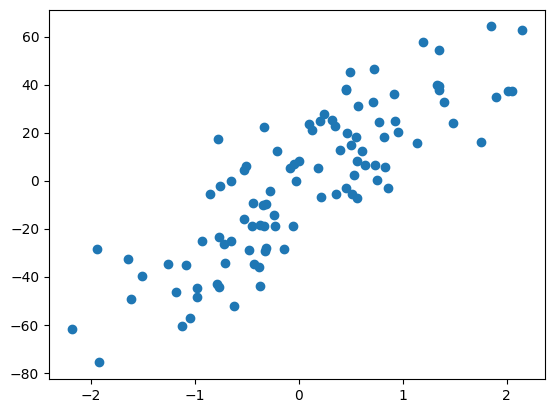

In [2]:
X,y = make_regression(n_samples=100, n_features=1, n_informative=1, n_targets=1,noise=20,random_state=13)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

plt.scatter(X,y)

from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train,y_train)
print(reg.coef_)
print(reg.intercept_)

c:\Users\SYED NAVEED\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\SYED NAVEED\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\SYED NAVEED\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.910e+03, tolerance: 7.164e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using on

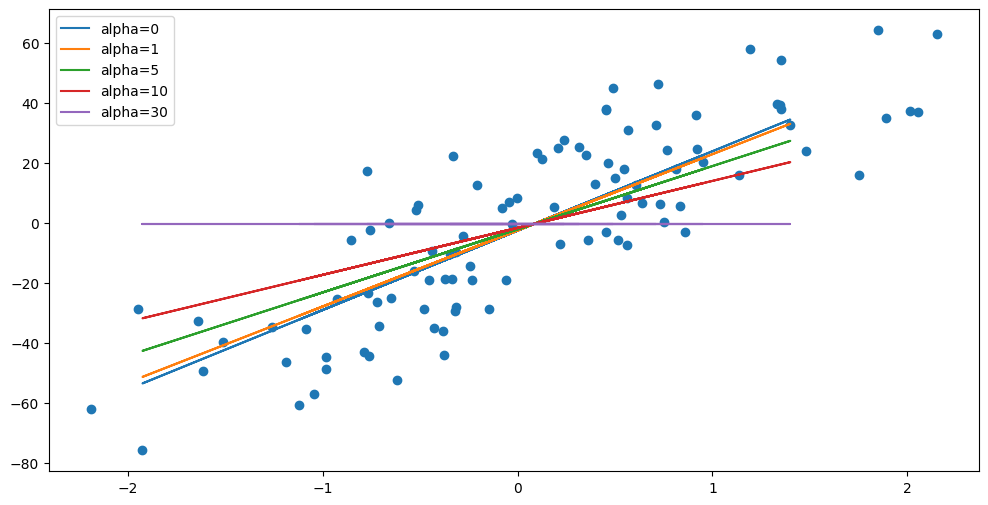

In [3]:
alphas = [0,1,5,10,30]
plt.figure(figsize=(12,6))
plt.scatter(X,y)
for i in alphas:
    L = Lasso(alpha=i)
    L.fit(X_train,y_train)
    plt.plot(X_test,L.predict(X_test),label='alpha={}'.format(i))
plt.legend()
plt.show()
    

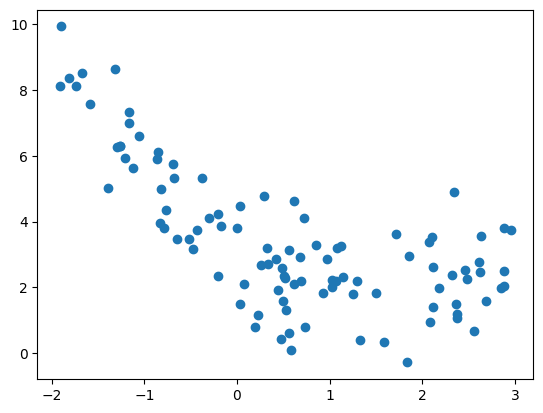

In [4]:
m = 100
x1 = 5 * np.random.rand(m, 1) - 2
x2 = 0.7 * x1 ** 2 - 2 * x1 + 3 + np.random.randn(m, 1)

plt.scatter(x1, x2)
plt.show()

c:\Users\SYED NAVEED\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\SYED NAVEED\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\SYED NAVEED\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.565e+01, tolerance: 4.633e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using on

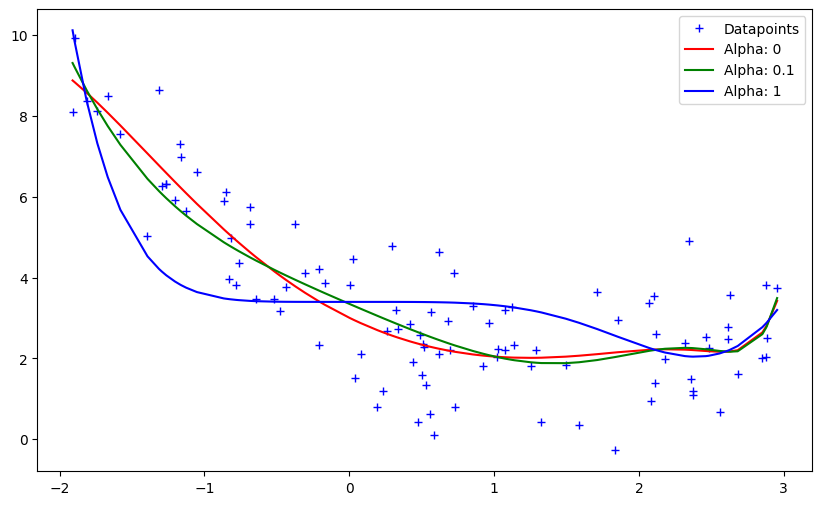

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

def get_preds_lasso(x1, x2, alpha):
    model = Pipeline([
        ('poly_feats', PolynomialFeatures(degree=16)),
        ('lasso', Lasso(alpha=alpha))
    ])
    model.fit(x1, x2)
    return model.predict(x1)

alphas = [0, 0.1, 1]
cs = ['r', 'g', 'b']

plt.figure(figsize=(10, 6))
plt.plot(x1, x2, 'b+', label='Datapoints')

for alpha, c in zip(alphas, cs):
    preds = get_preds_lasso(x1, x2, alpha)
    # Plot
    plt.plot(sorted(x1[:, 0]), preds[np.argsort(x1[:, 0])], c, label='Alpha: {}'.format(alpha))

plt.legend()
plt.show()

Here are **interview-ready answers** for **Lasso Regression**:

---

### 1️⃣ **How are coefficients affected?**

**A:**
Lasso Regression applies **L1 regularization**, which penalizes the absolute values of coefficients. This causes some coefficients to shrink **exactly to zero**, effectively performing **feature selection**. The model becomes sparse, retaining only the most important features.

---

### 2️⃣ **What happens to higher coefficients?**

**A:**
Lasso tends to **shrink smaller coefficients to zero** first, while **larger coefficients are reduced more gradually**. However, if regularization is strong enough, even high coefficients can be driven toward zero. This selective shrinking allows the model to focus on the most impactful predictors.

---

### 3️⃣ **Impact on Bias and Variance**

**A:**

* **Bias increases** because the model is less flexible (due to feature removal).
* **Variance decreases** because simpler models generalize better.
  This tradeoff improves performance, especially on noisy or high-dimensional data.

---

### 4️⃣ **Effect of regularization on loss function**

**A:**
Lasso modifies the ordinary least squares loss by adding an L1 penalty:

$$
J(\theta) = \sum_{i=1}^n (y^{(i)} - \theta^T x^{(i)})^2 + \lambda \sum_{j=1}^p |\theta_j|
$$

The **larger** the regularization parameter **\$\lambda\$**, the **stronger** the penalty on coefficients, increasing bias but reducing overfitting.

---

### 5️⃣ **Why is it called Lasso?**

**A:**
The name **LASSO** stands for **Least Absolute Shrinkage and Selection Operator**.

* **"Shrinkage"** refers to coefficient reduction.
* **"Selection"** refers to driving some coefficients to zero.
  The method was introduced by Robert Tibshirani in 1996 to combine regularization with automatic feature selection.

---

Let me know if you want comparison notes with Ridge or Elastic Net.


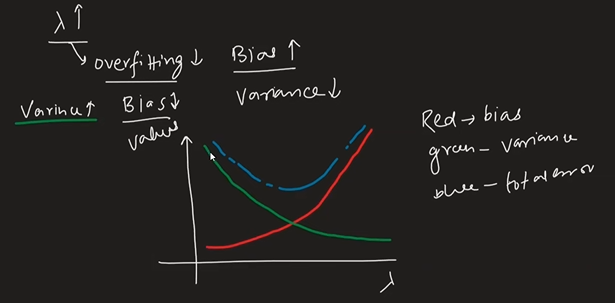